# DESCRIÇÃO

## *Como usar a programação para redesenhar as ruas da nossa cidade de forma mais automatizada?*

Estes cadernos Jupyter são exercícios para responder à pergunta acima. Possíveis caminhos para isso:

### 1. Desenhar um tipo de ciclovia de acordo com o tipo de rua

Em ruas residenciais, ciclorrota com moderação de tráfego.

Em ruas troncais, ciclovia segregada.

![image](https://user-images.githubusercontent.com/37457217/162640467-639d84d4-e2ae-43e1-a9ff-eed08629a3ba.png)

### 2. Permeabilidade filtrada

Instalar balizadores em pontos estratégicos de uma rua para fechá-la para carros, mas permitir o acesso a pé ou pedalando. Pendente.

### 3. Alargamento de calçadas

Obter a posição exata dos lotes na cidade. Em seguida, comparar esse mapa com o mapa da largura exata do leito carroçável. Por fim, dividir a calçada em trechos de acordo com sua largura. Pendente.

------------

# CÓDIGO

### Imports

In [1]:
import pandas as pd
import geopandas
import contextily as cx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry

%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'1.1.1'

## 1. Desenhar um tipo de ciclovia de acordo com o tipo de rua

### Listar colunas

In [2]:
def listar_colunas(geodataframe):
    print(geodataframe.columns.tolist())

### Gerar mapa

In [3]:
def gerar_mapa(geodataframe, colour="k", linestyle='solid', zoom_level="auto", size=(10, 10), alpha=0.7):
    
    ax = geodataframe.plot(edgecolor=colour, linestyle=linestyle, figsize=size, alpha=alpha)
    cx.add_basemap(ax, zoom=zoom_level, crs=geodataframe.crs, source=cx.providers.OpenStreetMap.Mapnik)

### Mudar valor condicionalmente

In [4]:
def mudar_valor_condicionalmente(on_column, value, on_new_column, new_value):
    sistema_viario.loc[sistema_viario[on_column] == value, on_new_column] = new_value

### Definindo o local

Escolhi o Grajaú por nenhum motivo muito relevante.

In [5]:
coordinates = (-22.92172,-43.25860)

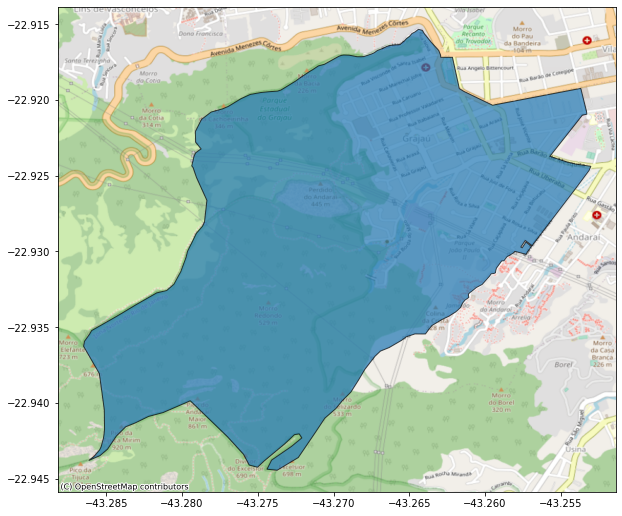

In [6]:
query = "Grajau, Rio de Janeiro"
bairro = ox.geocoder.geocode_to_gdf(query)
gerar_mapa(bairro)

### Extrair ruas dentro do bairro

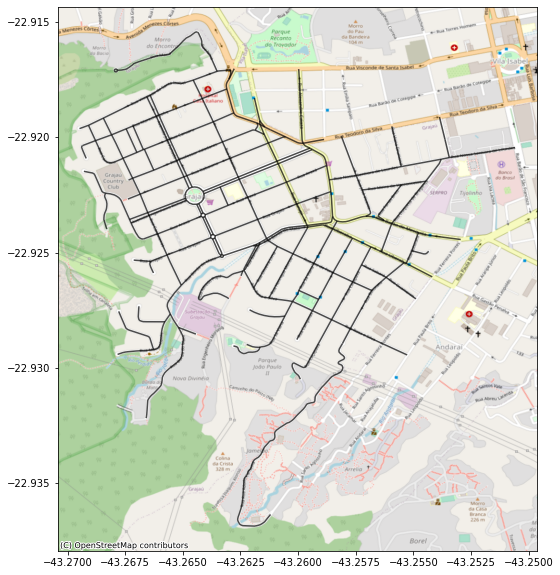

In [7]:
etiquetas = {"highway": ["trunk", "primary", "secondary", "tertiary", "residential"]}
grajau = ox.geometries_from_place(query, tags=etiquetas)
gerar_mapa(grajau)

### Extrair ruas num raio de n metros

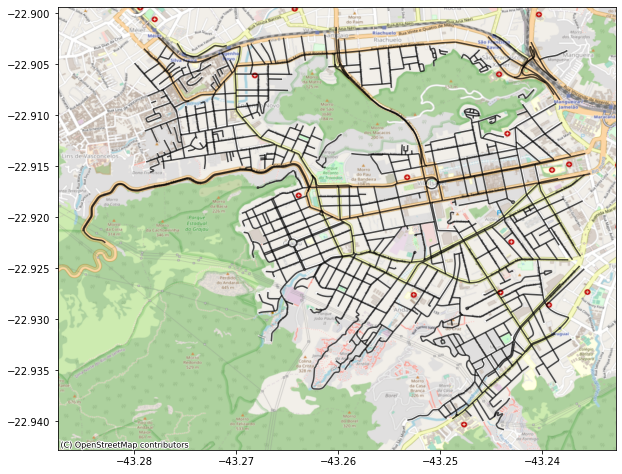

In [8]:
etiquetas = {"highway": ["trunk", "primary", "secondary", "tertiary", "residential"]}
sistema_viario = ox.geometries.geometries_from_point(coordinates, tags=etiquetas, dist=2000)
gerar_mapa(sistema_viario)

### Extrair ciclovias num raio de n metros

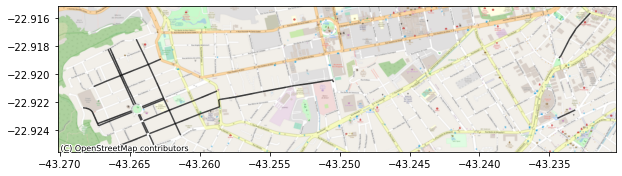

In [9]:
etiquetas= {"highway": "cycleway", "cycleway:right" : True, "cycleway:left": True, "cycleway:both" : True,
            "cycleway": ["lane", "shared_lane"]}
sistema_cicloviario = ox.geometries.geometries_from_point(coordinates, tags=etiquetas, dist=2500)
gerar_mapa(sistema_cicloviario)

### Extrair ruas por nível hierárquico

Definir Grajaú-Jacarepaguá e Túnel Noel Rosa como autoestradas

In [10]:
def definir_ruas_expressas(*nome_das_ruas):
    for nome in nome_das_ruas:
        sistema_viario.loc[sistema_viario.name == nome, "highway"] = "trunk"
        
definir_ruas_expressas("Túnel Noel Rosa", "Avenida Menezes Cortes",
                       "Viaduto Procurador José Alves de Morais", "Rua Linha Verde Procurador José Alves",
                       "Rua São Paulo, Rio de Janeiro")

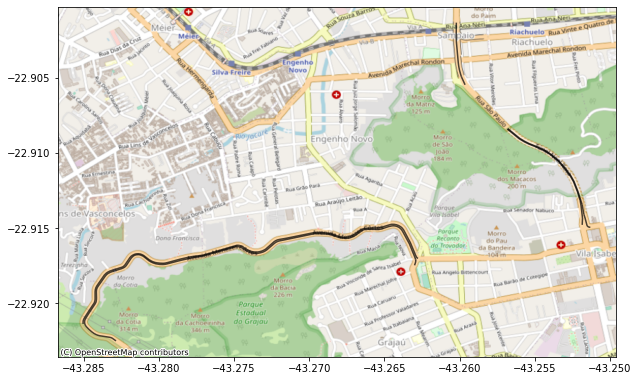

In [11]:
expressa = sistema_viario.loc[sistema_viario["highway"] == "trunk"]
gerar_mapa(expressa)

OBS: Considerar alterar `gerar_mapa()` para **não** gerar um mapa caso o geodataframe seja empty

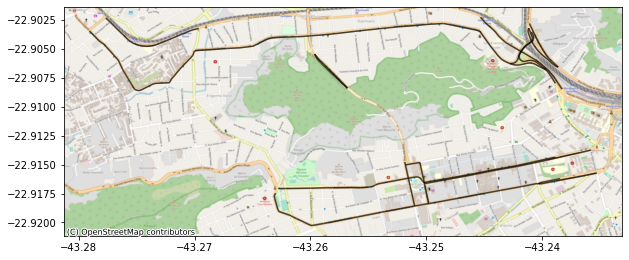

In [12]:
arterial_1 = sistema_viario.loc[sistema_viario["highway"] == "primary"]
gerar_mapa(arterial_1)

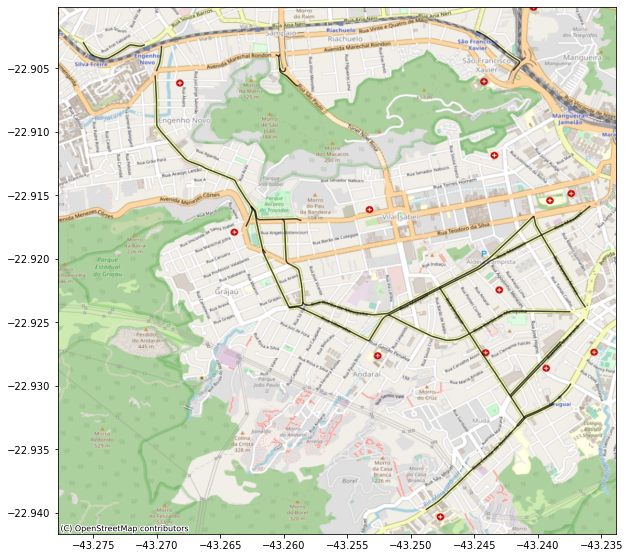

In [13]:
arterial_2 = sistema_viario.loc[sistema_viario["highway"] == "secondary"]
gerar_mapa(arterial_2)

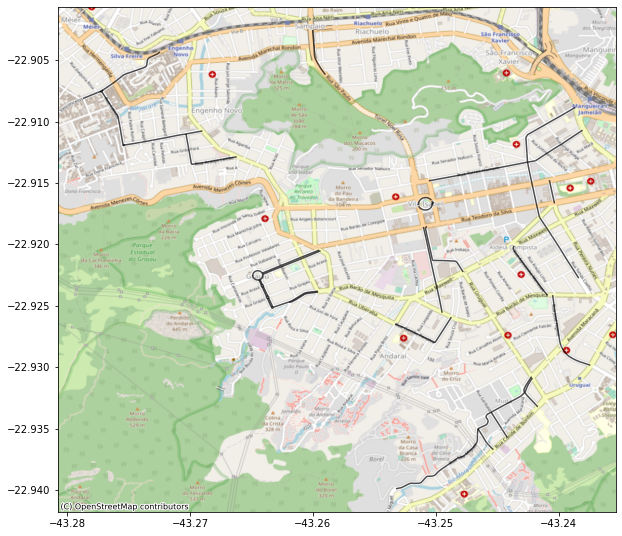

In [14]:
coletora = sistema_viario.loc[sistema_viario["highway"] == "tertiary"]
gerar_mapa(coletora)

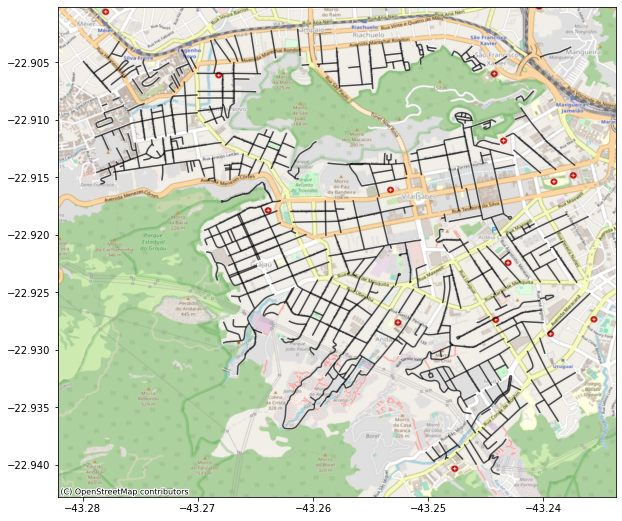

In [15]:
local = sistema_viario.loc[sistema_viario["highway"] == "residential"]
gerar_mapa(local)

### Gerar um novo mapa

Remover autoestradas para que o código não desenhe uma ciclovia junto a elas

In [16]:
sistema_viario.drop(sistema_viario[sistema_viario.highway == "trunk"].index, inplace=True)

### Aplicar ciclovia nas ruas de acordo com o nível hierárquico

REF: https://datagy.io/pandas-conditional-column/
thank you!!!

In [17]:
def aplicar_ciclovia_de_acordo_com_nivel_hierarquico():
    mudar_valor_condicionalmente("highway", "primary", "cycleway", "track")
    mudar_valor_condicionalmente("highway", "secondary", "cycleway", "track")
    mudar_valor_condicionalmente("highway", "tertiary", "cycleway", "lane")
    mudar_valor_condicionalmente("highway", "residential", "cycleway", "shared_lane")
    
aplicar_ciclovia_de_acordo_com_nivel_hierarquico()

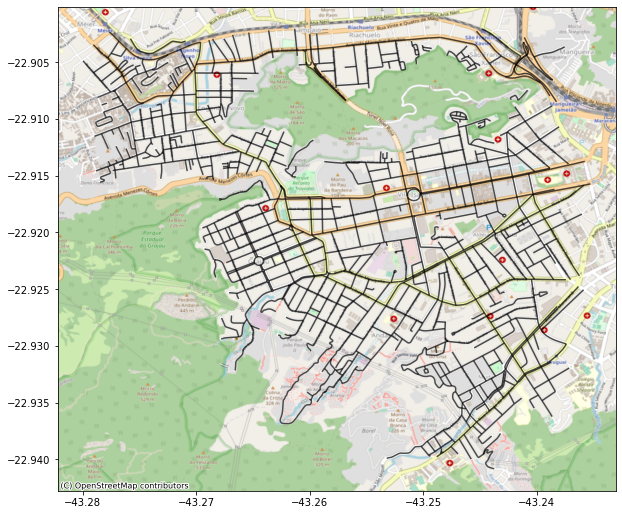

In [18]:
novo_sistema_cicloviario = sistema_viario.loc[sistema_viario.cycleway != np.NaN] # np.NaN or False, whatever
gerar_mapa(novo_sistema_cicloviario)

### Editar tracejado da ciclovia de acordo com seu tipo

REF: https://stackoverflow.com/questions/60587402/cannot-color-geodataframe-points 

In [19]:
conditions = [(sistema_viario.cycleway == "track"),
              (sistema_viario.cycleway == "lane"),
              (sistema_viario.cycleway == "shared_lane")]

values = ["solid",
          "dashed",
          "dotted"]

sistema_viario["line_style"] = np.select(conditions, values)

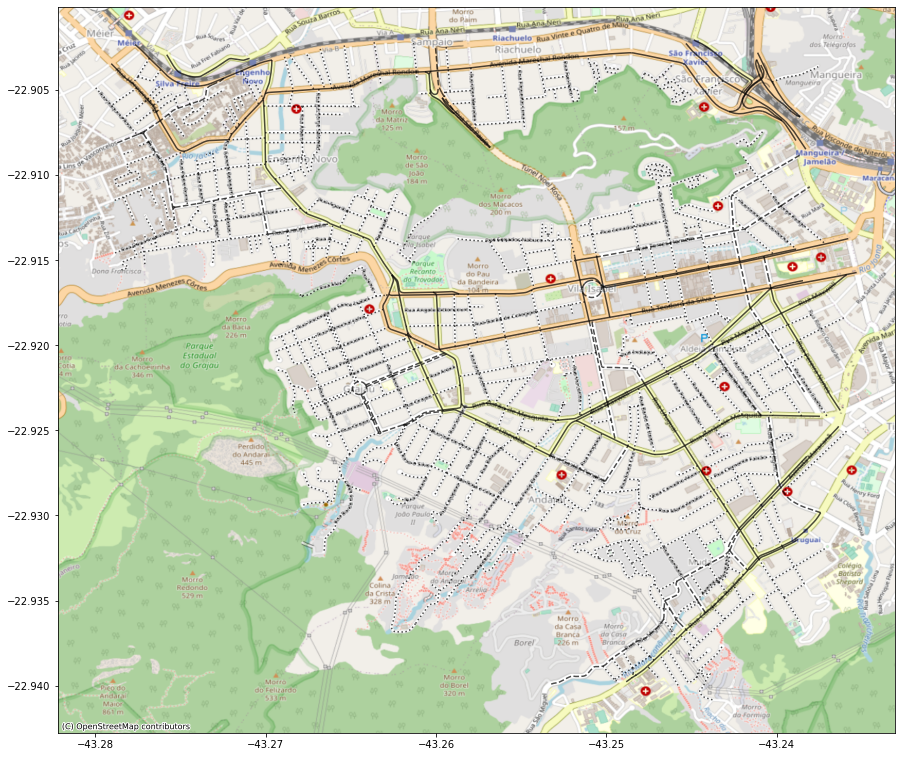

In [20]:
gerar_mapa(sistema_viario, linestyle=sistema_viario.line_style, size=(15, 15), zoom_level=15)

### Exportar

REF: https://gis.stackexchange.com/questions/343313/save-geodataframe-to-jpg-file

In [21]:
# gerar_mapa(sistema_viario, linestyle=sistema_viario.line_style, size=(50, 50), alpha=0.9)
# plt.savefig("grajaú.jpg")

## 2. Permeabilidade filtrada

Instalar balizadores na rua local em cruzamentos local-primária.

- Procurar os segmentos de ruas locais ligadas a um dos cruzamentos acima
- Adicionar um ponto na rua local, de preferência perto do cruzamento
- Adicionar a propriedade de bollard nesse ponto
    - ver como lidar com a falta de osmid para esse ponto

### Encontrando os cruzamentos entre ruas primárias e locais

https://automating-gis-processes.github.io/CSC18/lessons/L3/retrieve-osm-data.html

#### Código

In [22]:
grajau_graph = ox.graph_from_point(coordinates, network_type="drive")

nodes, edges = ox.graph_to_gdfs(grajau_graph)

cruzamentos = geopandas.sjoin(nodes, edges, how="inner")

cruzamentos.drop(["highway_left", "index_right2"], axis=1, inplace=True)

cruzamentos["node_osmid"] = cruzamentos.index

cruzamentos.rename(columns={"name": "part_of_road",
                            "osmid": "segment_osmid",
                            "highway_right": "highway", 
                            "index_right0": "node_a_of_segment",
                            "index_right1": "node_b_of_segment"}, inplace=True)

cruzamentos = cruzamentos[["street_count", "part_of_road", "highway", "node_a_of_segment",
                           "node_b_of_segment", "node_osmid", "segment_osmid", "oneway", "lanes",
                           "length", "width", "junction", "maxspeed", "access", "y", "x", "geometry"]]

cruzamentos = cruzamentos.loc[cruzamentos.street_count > 2]

In [23]:
primary_nodes = cruzamentos.loc[cruzamentos.highway == "primary"]
local_nodes = cruzamentos.loc[cruzamentos.highway == "residential"]
cruzamentos_primary_local = primary_nodes.index.intersection(local_nodes.index).values

mask = cruzamentos.index.isin(cruzamentos_primary_local)
cruzamentos_primary_local = cruzamentos.loc[mask]
cruzamentos_primary_local.reset_index(drop=True, inplace=True)

#### Tabela POINT

In [24]:
cruzamentos_primary_local

street_count             part_of_road      highway  node_a_of_segment  \
0              3   Rua José do Patrocínio      primary          267094989   
1              4   Avenida Menezes Cortes      primary         1782060305   
2              4         Rua Luís Barbosa      primary          456681495   
3              4         Rua Torres Homem      primary          402293759   
4              4         Rua Luís Barbosa  residential          402293759   
..           ...                      ...          ...                ...   
61             3   Avenida Menezes Cortes      primary         1782060341   
62             3  Rua Professor Valadares  residential         1786303750   
63             3   Rua José do Patrocínio      primary         1786303750   
64             3   Rua José do Patrocínio      primary         1834864371   
65             3   Rua José do Patrocínio      primary         1834864371   

    node_b_of_segment  node_osmid segment_osmid  oneway lanes   length width  \
0           456681995   456681995     210252849    True     3   50.147   NaN   
1           267094989  1782060305     318900084    True     2   45.757   NaN   
2           402293759   402293759     166974444    True     2  198.234   NaN   
3           402293760   402293759     142993585    True     2   78.302   NaN   
4           402293768   402293759     142993584    True   NaN  149.617   NaN   
..                ...         ...           ...     ...   ...      ...   ...   
61         1782060352  1782060341      40497173    True     2   47.705   NaN   
62         1921963261  1786303750     318899162    True   NaN   38.110   NaN   
63         1921963283  1786303750     172596631    True     3   15.582   NaN   
64         1786303750  1786303750     172596631    True     3  116.017   NaN   
65         1786303750  1834864371     172596631    True     3  116.017   NaN   

   junction maxspeed access          y          x                     geometry  
0       NaN      NaN    NaN -22.917898 -43.263092  POINT (-43.26309 -22.91790)  
1       NaN       50    NaN -22.917072 -43.262928  POINT (-43.26293 -22.91707)  
2       NaN      NaN    NaN -22.914822 -43.250558  POINT (-43.25056 -22.91482)  
3       NaN      NaN    NaN -22.914822 -43.250558  POINT (-43.25056 -22.91482)  
4       NaN      NaN    NaN -22.914822 -43.250558  POINT (-43.25056 -22.91482)  
..      ...      ...    ...        ...        ...                          ...  
61      NaN       50    NaN -22.916960 -43.262844  POINT (-43.26284 -22.91696)  
62      NaN      NaN    NaN -22.919373 -43.261787  POINT (-43.26179 -22.91937)  
63      NaN      NaN    NaN -22.919373 -43.261787  POINT (-43.26179 -22.91937)  
64      NaN      NaN    NaN -22.919373 -43.261787  POINT (-43.26179 -22.91937)  
65      NaN      NaN    NaN -22.918933 -43.262788  POINT (-43.26279 -22.91893)  

[66 rows x 17 columns]

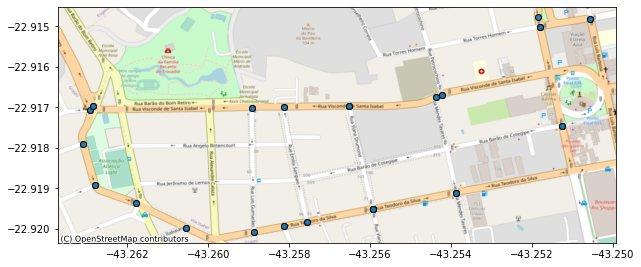

In [25]:
gerar_mapa(cruzamentos_primary_local)

### Encontrando os segmentos de rua local ligados aos cruzamentos acima

#### Código

In [26]:
mask = cruzamentos_primary_local.highway == "residential"
local_segments_points = cruzamentos_primary_local.loc[mask]
local_segments_points.reset_index(drop=True, inplace=True)

#### Tabela SEGMENTS

In [27]:
local_segments_points

# dar um jeito de limpar as listas de segment_osmid

street_count                  part_of_road      highway  \
0              4              Rua Luís Barbosa  residential   
1              4              Rua Torres Homem  residential   
2              3              Rua Petrocochino  residential   
3              3            Rua Mendes Tavares  residential   
4              3            Rua Emília Sampaio  residential   
5              3            Rua Marechal Jofre  residential   
6              3                   Rua Caruaru  residential   
7              3                 Rua Itabaiana  residential   
8              3            Rua Emília Sampaio  residential   
9              4  Rua Visconde de Santa Isabel  residential   
10             3              Rua José Vicente  residential   
11             4         Rua Barão de Cotegipe  residential   
12             4             Rua Viana Drumond  residential   
13             4             Rua Viana Drumond  residential   
14             3             Rua Viana Drumond  residential   
15             3             Rua Viana Drumond  residential   
16             4             Rua Viana Drumond  residential   
17             4             Rua Viana Drumond  residential   
18             4            Rua Mendes Tavares  residential   
19             4            Rua Mendes Tavares  residential   
20             3    Rua Barão de São Francisco  residential   
21             3            Rua Lins Guimarães  residential   
22             3            Rua Lins Guimarães  residential   
23             4  Rua Visconde de Santa Isabel  residential   
24             3  Rua Visconde de Santa Isabel  residential   
25             3       Rua Professor Valadares  residential   

    node_a_of_segment  node_b_of_segment  node_osmid          segment_osmid  \
0           402293759          402293768   402293759              142993584   
1           402293762         2283565714   402293762              798201164   
2           402293763          402293937   402293937              328735867   
3           402293938          496330986   402293938               40819802   
4          3639549955          402293941   402293941               39128573   
5           456681995          402294047   456681995               38560802   
6           402294049         1834864371  1834864371               50510339   
7           456681991          456681994   456681994               50510332   
8           468121395          468121392   468121395               39128573   
9           468121504         1782060305  1782060305              375148767   
10          468121561          468121553   468121561               39128579   
11          468121579         5334708116   468121579              284262758   
12          468121581          496330817   496330817              359201673   
13          496330817          468121581   496330817              359201673   
14          496330814          468121581   496330814               40819795   
15          468121581          496330814   496330814               40819795   
16          496330817          496330827   496330817               92246995   
17          496330827          496330817   496330817               92246995   
18          496330986          496330990   496330990              787841270   
19          496330990         2880064842   496330990  [799507954, 92247006]   
20          496331057         1390388850  1390388850              302014124   
21          642546864          642546867   642546864              358202249   
22          642546870          642546873   642546873              359201672   
23         1782060305         1782060341  1782060305              318900085   
24         1782060305         1782060341  1782060341              318900085   
25         1786303750         1921963261  1786303750              318899162   

    oneway lanes   length width junction maxspeed access          y  \
0     True   NaN  149.617   NaN      NaN      NaN    NaN -22.914822   
1     True     2  111.170 

In [28]:
mask = local.index.get_level_values(1).isin(local_segments_points.segment_osmid.values)
segments_to_place_a_bollard = local.loc[mask]

segments_to_place_a_bollard

highway  \
element_type osmid                    
way          38560802   residential   
             39128573   residential   
             39128579   residential   
             40819795   residential   
             40819802   residential   
             50510332   residential   
             50510339   residential   
             92246995   residential   
             142993584  residential   
             284262758  residential   
             302014124  residential   
             318899162  residential   
             318900085  residential   
             328735867  residential   
             358202249  residential   
             359201672  residential   
             359201673  residential   
             375148767  residential   
             787841270  residential   
             798201164  residential   

                                                                 geometry  \
element_type osmid                                                          
way          38560802   LINESTRING (-43.26309 -22.91790, -43.26374 -22...   
             39128573   LINESTRING (-43.25756 -22.91983, -43.25777 -22...   
             39128579   LINESTRING (-43.25812 -22.91995, -43.25748 -22...   
             40819795   LINESTRING (-43.25651 -22.91698, -43.25618 -22...   
             40819802   LINESTRING (-43.25437 -22.91676, -43.25439 -22...   
             50510332   LINESTRING (-43.26129 -22.92024, -43.26067 -22...   
             50510339   LINESTRING (-43.26760 -22.92090, -43.26699 -22...   
             92246995   LINESTRING (-43.25594 -22.91952, -43.25590 -22...   
             142993584  LINESTRING (-43.25056 -22.91482, -43.25082 -22...   
             284262758  LINESTRING (-43.25126 -22.91746, -43.25211 -22...   
             302014124  LINESTRING (-43.25209 -22.91378, -43.25190 -22...   
             318899162  LINESTRING (-43.26179 -22.91937, -43.26177 -22...   
             318900085  LINESTRING (-43.26293 -22.91707, -43.26290 -22...   
             328735867  LINESTRING (-43.25455 -22.91554, -43.25448 -22...   
             358202249  LINESTRING (-43.25893 -22.91701, -43.25892 -22...   
             359201672  LINESTRING (-43.25890 -22.91885, -43.25888 -22...   
             359201673  LINESTRING (-43.25618 -22.91849, -43.25597 -22...   
             375148767  LINESTRING (-43.26909 -22.91947, -43.26844 -22...   
             787841270  LINESTRING (-43.25411 -22.91804, -43.25389 -22...   
             798201164  LINESTRING (-43.25180 -22.91503, -43.25287 -22...   

                       source maxspeed access                          name  \
element_type osmid                                                            
way          38560802     NaN      NaN    NaN            Rua Marechal Jofre   
             39128573     NaN       30    NaN            Rua Emília Sampaio   
             39128579   Yahoo      NaN    NaN              Rua José Vicente   
             40819795     NaN      NaN    NaN             Rua Viana Drumond   
             40819802     NaN      NaN    NaN            Rua Mendes Tavares   
             50510332     NaN      NaN    NaN                 Rua Itabaiana   
             50510339   Yahoo      NaN    NaN                   Rua Caruaru   
             92246995     NaN      NaN    NaN             Rua Viana Drumond   
             142993584    NaN      NaN    NaN              Rua Luís Barbosa   
             284262758    NaN      NaN    NaN         Rua Barão de Cotegipe   
             302014124    NaN      NaN    NaN    Rua Barão de São Francisco   
             318899162    NaN      NaN    NaN       Rua Professor Valadares   
             318900085    NaN      NaN     no  Rua Visconde de Santa Isabel   
             328735867    NaN      NaN    NaN              Rua Petrocochino   
             358202249    NaN      NaN    NaN            Rua Lins Guimarães   
             359201672    NaN      NaN    NaN            Rua Lins Guimarães   
             359201673    NaN      NaN    NaN       

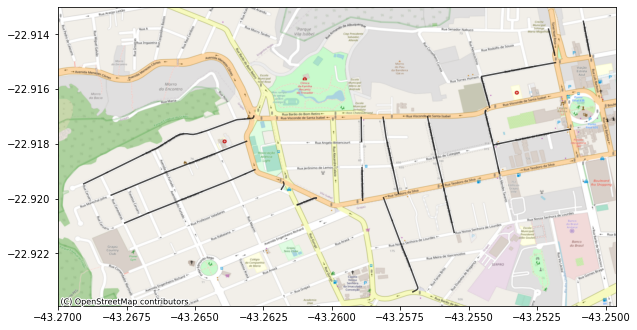

In [29]:
gerar_mapa(segments_to_place_a_bollard)

### Instalando um balizador

#### Instalando um balizador nos segmentos acima

No momento, só sei instalar o balizador no meio do segmento. Meu objetivo é instalá-lo perto do cruzamento.

##### Código

In [30]:
# Iterate the segments above, take their geometry and use it to make a new point

# Ainda falta a parte do "iterate". Por enquanto, o código pela uma rua de exemplo. O número 0 representa a rua na tabela.

example = 0

segment_geometry = segments_to_place_a_bollard.geometry[example]
distance = 1
bollard = segment_geometry.interpolate(distance)

In [31]:
bollard.x

-43.2680876

#### Criando novo geodataframe só com esses pontos bollards

##### Código

In [32]:
example = 0

new_bollard_df = pd.DataFrame({"name": segments_to_place_a_bollard.name[example],
                               "traffic_calming": ["bollard"],
                               "x": bollard.x,
                               "y": bollard.y,
                               "geometry": [bollard.wkt]})

new_bollard_df.geometry = geopandas.GeoSeries.from_wkt(new_bollard_df.geometry)

bollards_gdf = geopandas.GeoDataFrame(new_bollard_df, geometry="geometry")

##### Resultado

In [33]:
# só tem uma rua, logo, somente 1 ponto

bollards_gdf

name traffic_calming          x          y  \
0  Rua Marechal Jofre         bollard -43.268088 -22.919884   

                      geometry  
0  POINT (-43.26809 -22.91988)

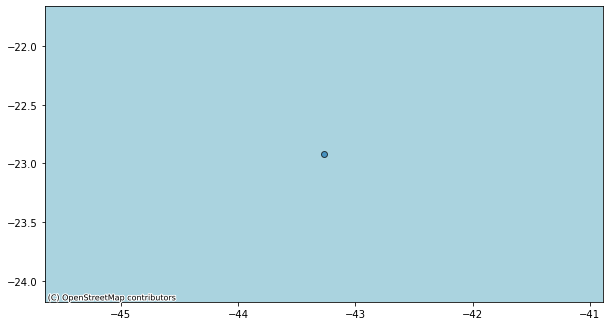

In [34]:
gerar_mapa(bollards_gdf, zoom_level=6)

#### Concatenando a tabela de bollards com a tabela de ruas locais

https://geopandas.org/docs/user_guide/mergingdata.html

#### Adicionando a geometry do ponto à geometry do segmento

REF: https://stackoverflow.com/questions/14084290/add-new-points-to-existing-polygon-in-shapely

In [35]:
linestring_do_trecho = sistema_viario

linestring_do_trecho_coordinates = linestring_do_trecho.coords

list(linestring_do_trecho_coordinates)

AttributeError: 'GeoDataFrame' object has no attribute 'coords'

#### Adicionando as coordenadas desse ponto à lista de coordenadas de pontos do segmento

In [ ]:
linestring_with_bollard = list(linestring_do_trecho_coordinates) + list(bollard_coordinates)

In [ ]:
linestring_with_bollard

#### Atualizando a lista de coordenadas no geodataframe da rua de exemplo

In [ ]:
new_linestring = shapely.geometry.LineString(linestring_with_bollard)

rua_itabaiana_trecho.geometry[0] = new_linestring

In [ ]:
rua_itabaiana_trecho

REF: https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=footprints#module-osmnx.graph